In [1]:
import os
import tensorflow as tf
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras_vggface.vggface import VGGFace

from keras.applications import VGG19
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras import regularizers
from keras.models import Model, load_model

from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import pandas as pd

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [4]:
train_data_dir = r'W:/RAFDB/RAFDB/train/'
validation_data_dir = r'W:/RAFDB/RAFDB/val/'

In [5]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
CHANNELS = 3
num_classes = 7

batch_size=32*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)
class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [6]:
# Init the Image Data Generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train Images
train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
)

# Validation images (From Train Images)
validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'
)

Found 10733 images belonging to 7 classes.
Found 4606 images belonging to 7 classes.


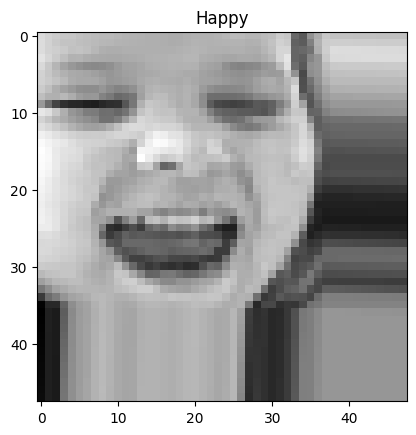

In [7]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [8]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,606,613,248,4169,2242,1722,1133
test,261,264,107,1788,962,738,486


In [9]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

10733
4606


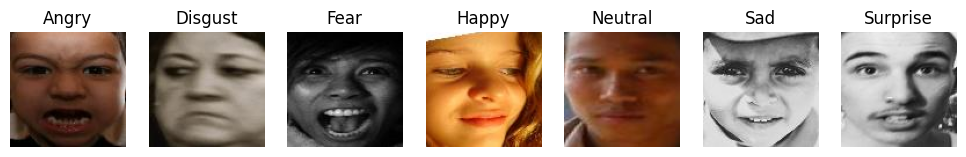

In [10]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [13]:
# Compute the class weights
class_to_idx=validation_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(class_weights)

# Callbacks

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
{0: 6.87953795379538, 1: 6.800978792822186, 2: 16.81048387096774, 3: 1.0, 4: 1.8595004460303302, 5: 2.421022067363531, 6: 3.679611650485437}


In [14]:
with strategy.scope():

    # Load the VGG19 model
    base_model = VGG16( 
        weights=None,
        include_top=False, 
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x) 
    predictions = Dense(7, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)       

In [15]:
# Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=30,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
167/167 [==============================] - ETA: 0s - loss: 5.2830 - accuracy: 0.1302
Epoch 1: val_accuracy improved from -inf to 0.34419, saving model to best_model.h5
167/167 [==============================] - 27s 101ms/step - loss: 5.2830 - accuracy: 0.1302 - val_loss: 1.9452 - val_accuracy: 0.3442 - lr: 1.0000e-04
Epoch 2/30
167/167 [==============================] - ETA: 0s - loss: 5.2859 - accuracy: 0.3050
Epoch 2: val_accuracy did not improve from 0.34419
167/167 [==============================] - 17s 

In [16]:
save_model = model.save('VGG16_SCRATCH_50e_FER.h5')

In [ ]:
model = load_model("VGG16_Scract_100e_TF_FT_RAFDB.h5")

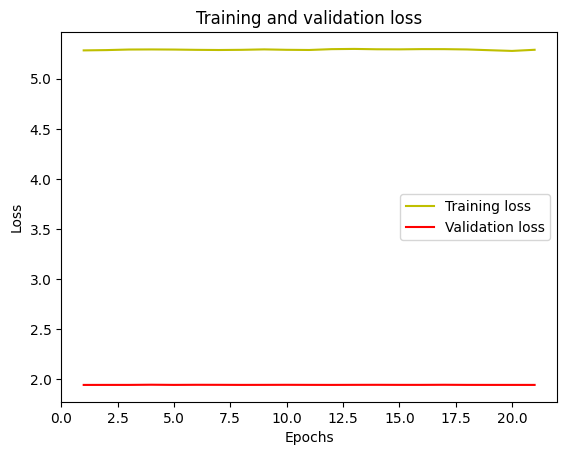

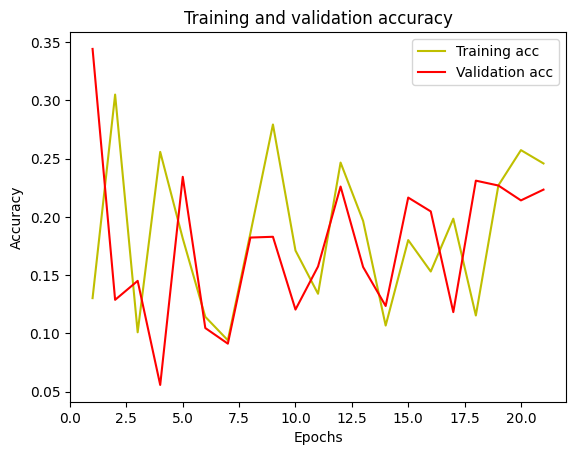

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 2s 10ms/step
Accuracy =  0.265625


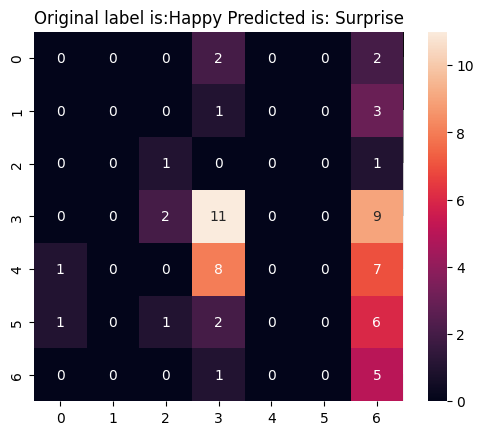

In [18]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Model Evaluation

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
2/2 [==============================] - 0s 19ms/step
Accuracy =  0.328125


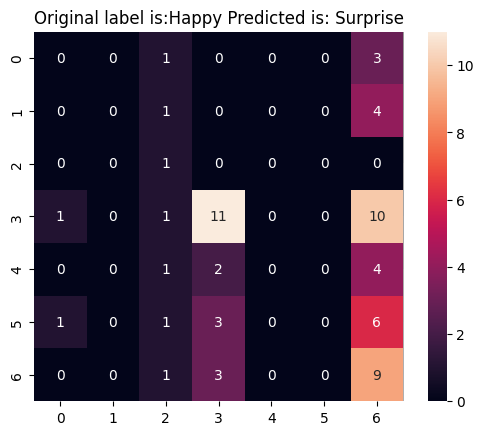

2/2 [==============================] - 0s 15ms/step
Accuracy =  0.109375


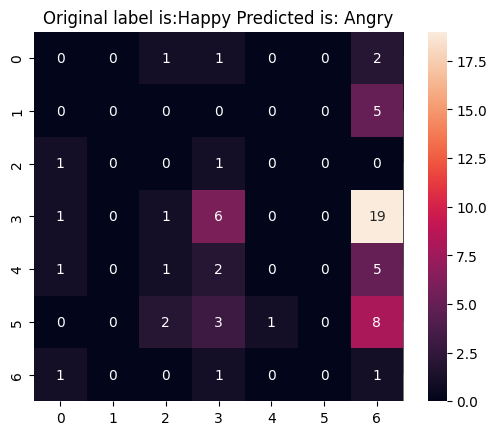

In [19]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [20]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.2243


In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 39ms/step
Accuracy: 22.425176056338028
Angry 261/4606 acc: 10.7
Disgust 259/4606 acc: 0.0
Fear 106/4606 acc: 28.3
Happy 1758/4606 acc: 36.6
Neutral 948/4606 acc: 1.1
Sad 732/4606 acc: 0.0
Surprise 480/4606 acc: 64.2


In [22]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 22.425176056338028
Angry 261/4606 acc: 10.7
Disgust 259/4606 acc: 0.0
Fear 106/4606 acc: 28.3
Happy 1758/4606 acc: 36.6
Neutral 948/4606 acc: 1.1
Sad 732/4606 acc: 0.0
Surprise 480/4606 acc: 64.2


              precision    recall  f1-score   support

       Angry       0.17      0.11      0.13       261
     Disgust       0.00      0.00      0.00       259
        Fear       0.08      0.28      0.13       106
       Happy       0.46      0.37      0.41      1758
     Neutral       0.31      0.01      0.02       948
         Sad       0.00      0.00      0.00       732
    Surprise       0.12      0.64      0.20       480

    accuracy                           0.22      4544
   macro avg       0.16      0.20      0.13      4544
weighted avg       0.27      0.22      0.19      4544



c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

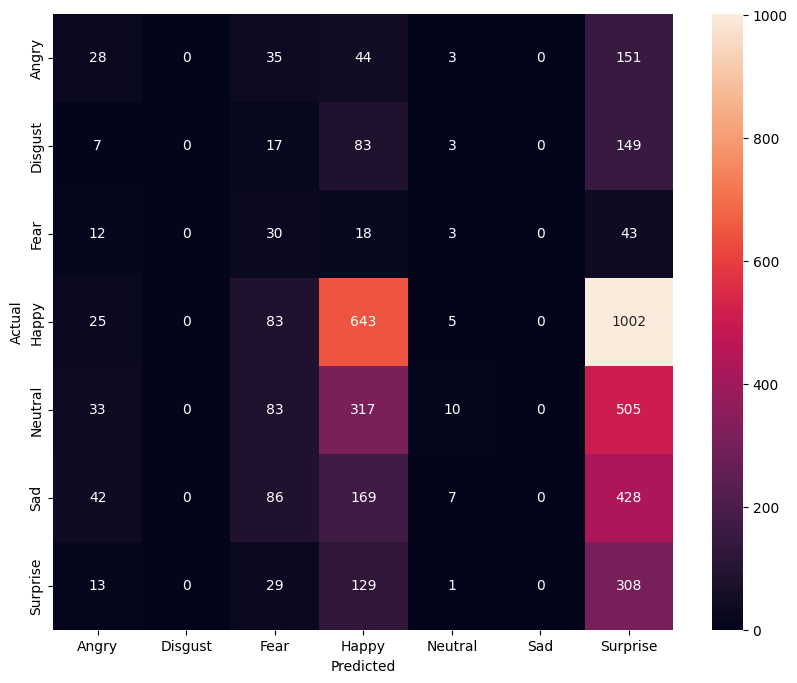

In [23]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with images

In [24]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 2s 2s/step
Predicted emotion class: surprise, probability: 0.14429448544979095
1/1 [==============================] - 0s 97ms/step
Predicted emotion class: surprise, probability: 0.1451665461063385
1/1 [==============================] - 0s 96ms/step
Predicted emotion class: surprise, probability: 0.14478012919425964
1/1 [==============================] - 0s 99ms/step
Predicted emotion class: surprise, probability: 0.14396755397319794
1/1 [==============================] - 0s 94ms/step
Predicted emotion class: surprise, probability: 0.14401733875274658
1/1 [==============================] - 0s 97ms/step
Predicted emotion class: surprise, probability: 0.14500053226947784
1/1 [==============================] - 0s 95ms/step
Predicted emotion class: surprise, probability: 0.14401309192180634
1/1 [==============================] - 0s 103ms/step
Predicted emotion class: fear, probability: 0.14308440685272217
1/1 [==============================] - 0s 96ms

# Unseen batch

In [25]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [26]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


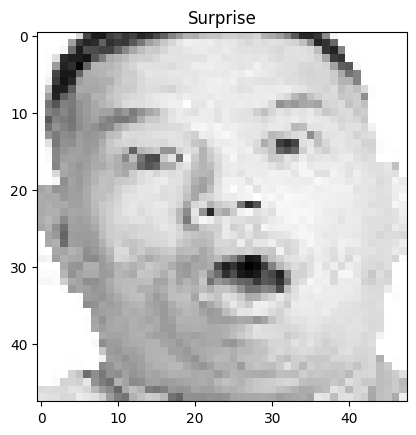

In [27]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Worst batch saved
2/2 [==============================] - 0s 39ms/step
Accuracy =  0.25


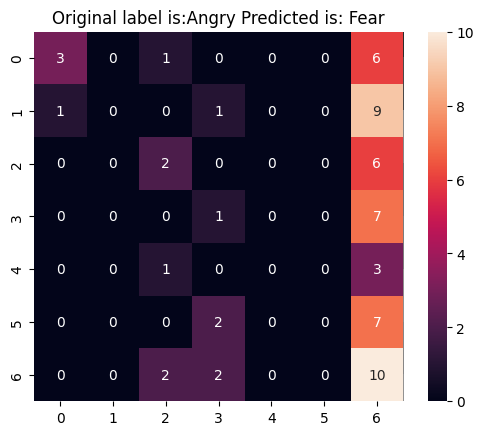

2/2 [==============================] - 0s 39ms/step
Accuracy =  0.046875


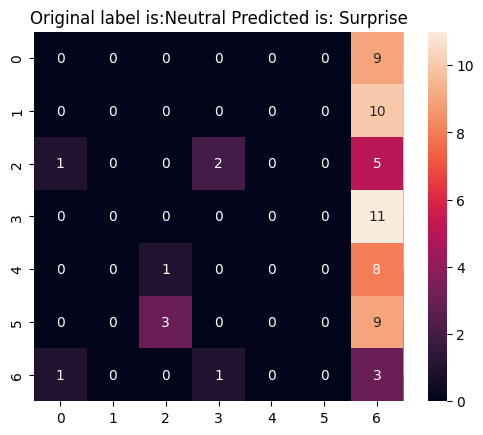

In [28]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [29]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.1582


In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 41ms/step
Accuracy: 15.8203125
Angry 292/2100 acc: 8.6
Disgust 292/2100 acc: 0.0
Fear 294/2100 acc: 8.2
Happy 294/2100 acc: 6.8
Neutral 293/2100 acc: 0.0
Sad 295/2100 acc: 0.0
Surprise 288/2100 acc: 88.5


# Accuracy global and per class

In [31]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 15.8203125
Angry 292/2100 acc: 8.6
Disgust 292/2100 acc: 0.0
Fear 294/2100 acc: 8.2
Happy 294/2100 acc: 6.8
Neutral 293/2100 acc: 0.0
Sad 295/2100 acc: 0.0
Surprise 288/2100 acc: 88.5


              precision    recall  f1-score   support

       Angry       0.27      0.09      0.13       292
     Disgust       0.00      0.00      0.00       292
        Fear       0.17      0.08      0.11       294
       Happy       0.13      0.07      0.09       294
     Neutral       0.00      0.00      0.00       293
         Sad       0.00      0.00      0.00       295
    Surprise       0.15      0.89      0.26       288

    accuracy                           0.16      2048
   macro avg       0.10      0.16      0.08      2048
weighted avg       0.10      0.16      0.08      2048



c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\darks\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

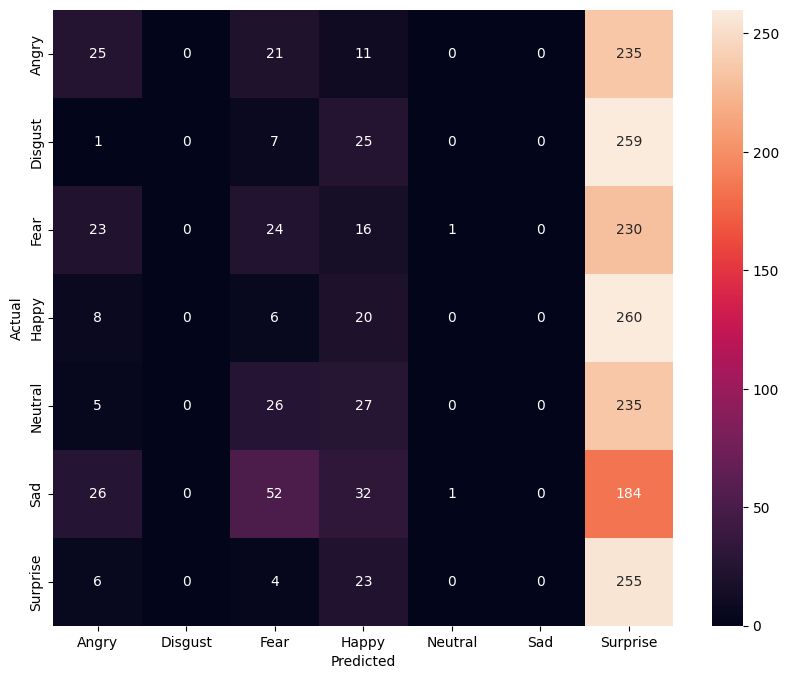

In [32]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Fine Tunning

In [33]:
with strategy.scope():

    model = load_model('best_model.h5')
    
    # # Load the VGG19 model
    # base_model = VGG16(
    #     weights='imagenet', 
    #     include_top=False, 
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    for layer in model.layers:
        layer.trainable = True
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    # inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # x = base_model(inputs)
    # x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x) 
    # predictions = Dense(7, activation='softmax')(x)

    # # Compile the model
    # model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 7)                 903 

In [34]:
    # Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=200,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 32 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 32 all-reduces with algorithm = hierarchical_copy, num_packs = 1
166/167 [============================>.] - ETA: 0s - loss: 5.2662 - accuracy: 0.1401
Epoch 1: val_accuracy improved from 0.34419 to 0.38424, saving model to best_model.h5
167/167 [==============================] - 19s 76ms/step - loss: 5.2624 - accuracy: 0.1409 - val_loss: 1.8603 - val_accuracy: 0.3842 - lr: 1.0000e-04
Epoch 2/200
167/167 [==============================] - ETA: 0s - loss: 5.1334 - accuracy: 0.2992
Epoch 2: val_accuracy did not improve from 0.38424
167/167 [==============================] - 12s 73ms/step - loss: 5.1334 - accuracy: 0.2992 - val_loss: 2.1014 - val_accuracy: 0.3323 - lr: 1.0000e-04
Epoch 3/200
167/167 [==============================] - ETA: 0s - loss: 5.1319 - accuracy: 0.3053
Epoch 3: val_accuracy did not improve from 0.38424
167/167 [==============

In [36]:
save_model = model.save('VGG16_Scract_100e_TF_FT_RAFDB.h5')

# Fine Tunning model evaluation

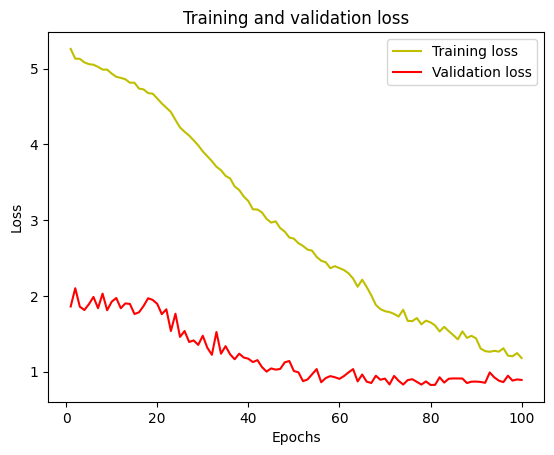

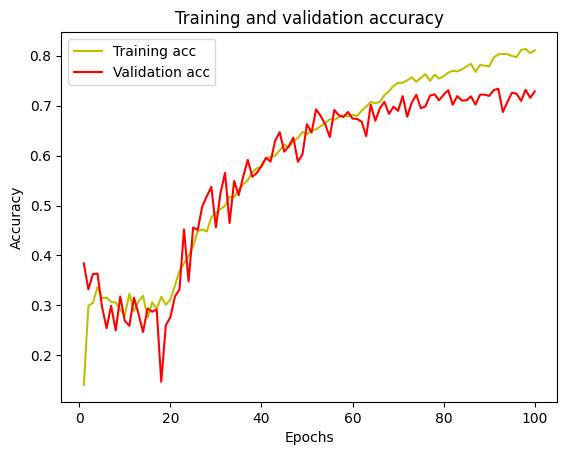

In [37]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 1s 87ms/step
Accuracy =  0.671875


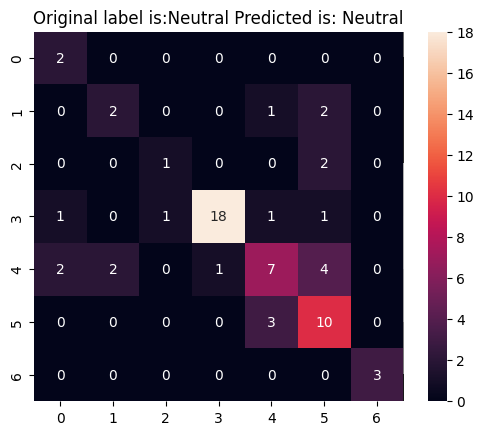

In [38]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
2/2 [==============================] - 0s 42ms/step
Accuracy =  0.84375


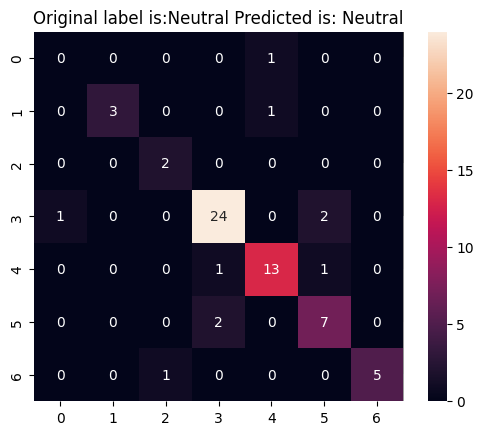

2/2 [==============================] - 0s 43ms/step
Accuracy =  0.5625


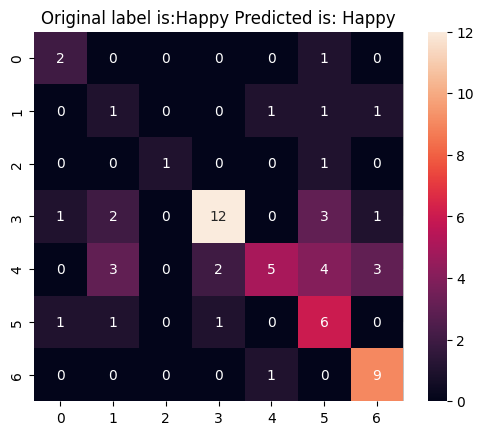

In [39]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [40]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.7295


In [41]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 42ms/step
Accuracy: 72.95334507042254
Angry 259/4606 acc: 77.6
Disgust 260/4606 acc: 48.5
Fear 105/4606 acc: 48.6
Happy 1765/4606 acc: 81.7
Neutral 942/4606 acc: 56.8
Sad 730/4606 acc: 78.5
Surprise 483/4606 acc: 80.1


In [42]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 72.95334507042254
Angry 259/4606 acc: 77.6
Disgust 260/4606 acc: 48.5
Fear 105/4606 acc: 48.6
Happy 1765/4606 acc: 81.7
Neutral 942/4606 acc: 56.8
Sad 730/4606 acc: 78.5
Surprise 483/4606 acc: 80.1


              precision    recall  f1-score   support

       Angry       0.59      0.78      0.67       259
     Disgust       0.42      0.48      0.45       260
        Fear       0.43      0.49      0.46       105
       Happy       0.94      0.82      0.87      1765
     Neutral       0.75      0.57      0.64       942
         Sad       0.56      0.78      0.66       730
    Surprise       0.75      0.80      0.77       483

    accuracy                           0.73      4544
   macro avg       0.63      0.67      0.65      4544
weighted avg       0.76      0.73      0.74      4544



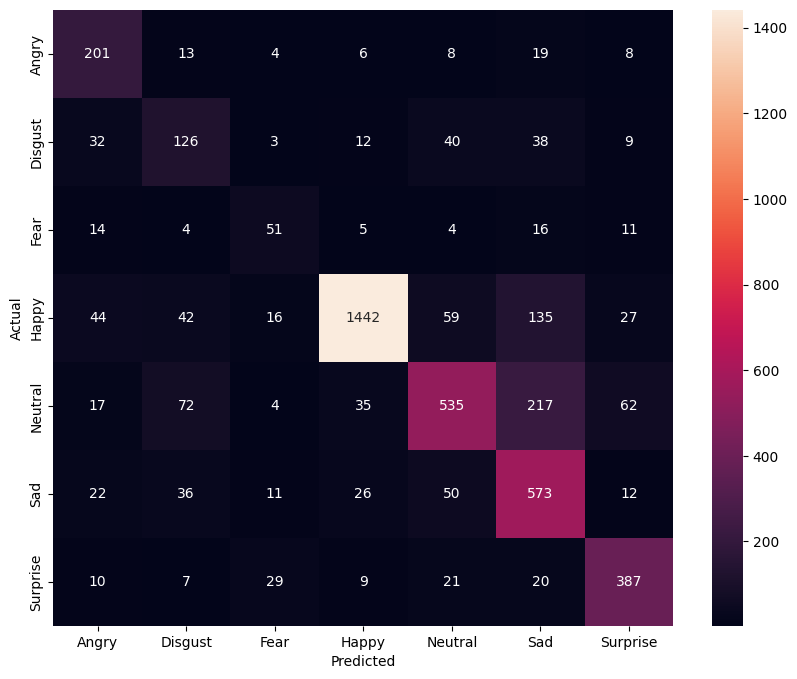

In [43]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [44]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [45]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


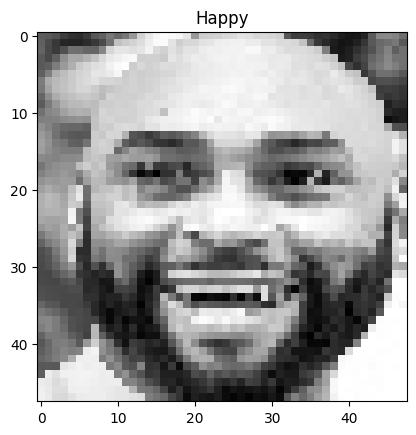

In [46]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
2/2 [==============================] - 0s 40ms/step
Accuracy =  0.59375


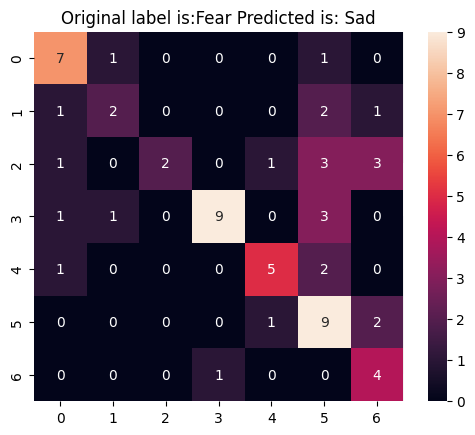

2/2 [==============================] - 0s 86ms/step
Accuracy =  0.3125


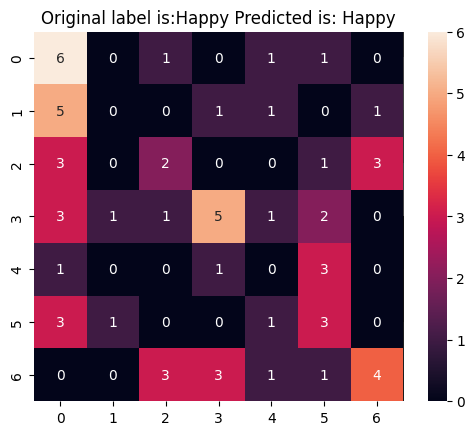

In [47]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [48]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.4736


In [49]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 40ms/step
Accuracy: 47.36328125
Angry 289/2100 acc: 65.7
Disgust 290/2100 acc: 33.8
Fear 293/2100 acc: 15.7
Happy 292/2100 acc: 53.8
Neutral 296/2100 acc: 45.6
Sad 294/2100 acc: 51.0
Surprise 294/2100 acc: 66.0


# Accuracy global and per class

In [50]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 47.36328125
Angry 289/2100 acc: 65.7
Disgust 290/2100 acc: 33.8
Fear 293/2100 acc: 15.7
Happy 292/2100 acc: 53.8
Neutral 296/2100 acc: 45.6
Sad 294/2100 acc: 51.0
Surprise 294/2100 acc: 66.0


              precision    recall  f1-score   support

       Angry       0.42      0.66      0.51       289
     Disgust       0.45      0.34      0.39       290
        Fear       0.46      0.16      0.23       293
       Happy       0.66      0.54      0.59       292
     Neutral       0.53      0.46      0.49       296
         Sad       0.40      0.51      0.45       294
    Surprise       0.47      0.66      0.55       294

    accuracy                           0.47      2048
   macro avg       0.48      0.47      0.46      2048
weighted avg       0.48      0.47      0.46      2048



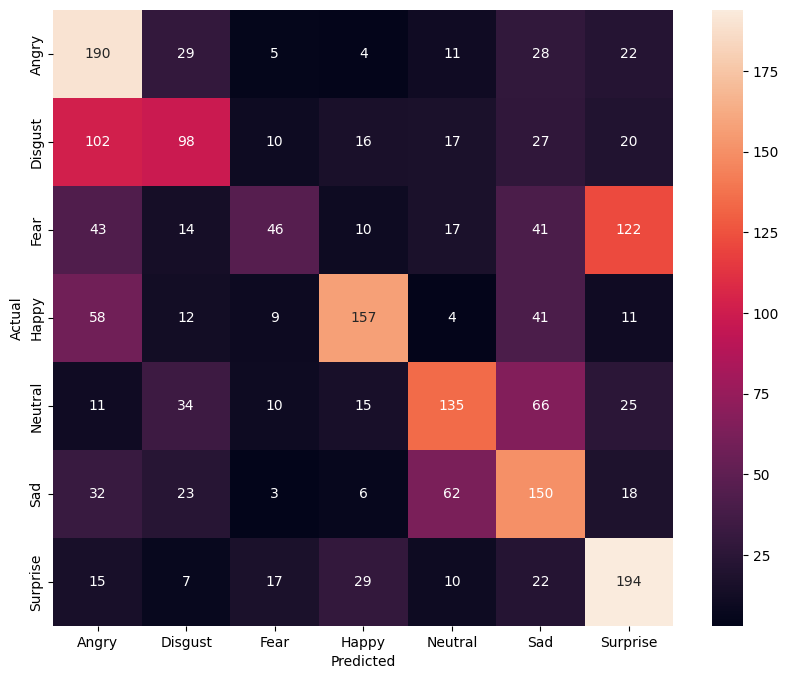

In [51]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test it with real images

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
